# Optimisation of GCI circuit in quantinuum

In [13]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket.qasm
from datetime import datetime
from quantinuum_utils import *
import qnexus as qnx  
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
os.chdir('..')
optimizer = 'sgd'
nqubits = 4
nlayer = 1
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ.qasm'
gci_circ_file = folder_path + 'gci_circ.qasm'

In [3]:
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
gci_circ = pytket.qasm.circuit_from_qasm(gci_circ_file)

In [6]:
# connect to nexus account
qnx.client.auth.login()

🌐 Browser log in initiated.


╭────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                        │
│         Confirm that the browser shows the following code and click 'allow device':    │
│                                                                                        │
│                                      gnAlmA                                            │
│                                                                                        │
╰────────────────────────────────────────────────────────────────────────────────────────╯

Browser didn't open automatically? Use this link: https://nexus.quantinuum.com/auth/device/browser?otp=gnAlmAlFRd1ZYDdycpIcqroocNNa7iCJ_oMkGBPlfXPz-UCJdkNW3bG1mwsi7jpEzwkfcQrBHk8WWIOwfU1fGg
✅ Successfully logged in as xiaoyue.li@ntu.edu.sg using the browser.


In [7]:
# connect to nexus project
project_name = "boostvqe_XXZ_optimisation"
project_ref = qnx.projects.get_or_create(name=project_name)
project_ref.df()

# set this in the context
qnx.context.set_active_project(project_ref)

## Create measurement setup

In [8]:
# XXZ model
nqubits = 4
delta = 0.5
terms = {}
for i in range(nqubits):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.X, (i+1)%nqubits: Pauli.X}, 1)
    term_y_i = create_qubit_pauli_string(nqubits, {i: Pauli.Y, (i+1)%nqubits: Pauli.Y}, 1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, delta)
    terms.update(term_x_i)
    terms.update(term_y_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)

In [9]:
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)

## Generate measurement circuits

In [10]:
# create list of circuits for measurement in different bases
vqe_circuit_ref_list = []
gci_circuit_ref_list = []
for i, mc in enumerate(measurement_setup.measurement_circs):
    c = vqe_circ.copy()
    c.append(mc)
    measurement_vqe_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement vqe circuit {i}",
            )
    c = gci_circ.copy()
    c.append(mc)
    measurement_gci_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement gci circuit {i}",
            )
    vqe_circuit_ref_list.append(measurement_vqe_circuit_ref)
    gci_circuit_ref_list.append(measurement_gci_circuit_ref)

## Run optimization levels

In [12]:
from pytket.circuit import OpType
from datetime import datetime

# Define your optimization levels
optimization_levels = [0,1,2]

# Dictionary to store compiled circuits per optimization level
vqe_compiled_circuits_dict = {}
gci_compiled_circuits_dict = {}

# Compile circuits for each optimization level
for opt_level in optimization_levels:
    vqe_compile_job = qnx.compile(
        name=f"compile_job_VQE_opt_{opt_level}_{datetime.now()}",
        circuits=vqe_circuit_ref_list,
        optimisation_level=opt_level,
        backend_config=qnx.QuantinuumConfig(device_name='H1-Emulator'),
        timeout=None,
    )
    vqe_compiled_circuits_dict[opt_level] = vqe_compile_job
    gci_compile_job = qnx.compile(
        name=f"compile_job_GCI_opt_{opt_level}_{datetime.now()}",
        circuits=gci_circuit_ref_list,
        optimisation_level=opt_level,
        backend_config=qnx.QuantinuumConfig(device_name='H1-Emulator'),
        timeout=None,
    )
    gci_compiled_circuits_dict[opt_level] = gci_compile_job

## Analyze circuit composition

In [14]:
# Function to retrieve and analyze compiled circuits from a compile job
def retrieve_and_analyze_compiled_circuits(compile_jobs, opt_level):
    """Waits for jobs to complete, downloads results, and analyzes gate counts."""
    job = compile_jobs[0]
    # Download the compiled circuit
    compiled_circuit = job.download_circuit()
    
    # Analyze gate counts
    circuit_depth = compiled_circuit.depth()
    total_gates = compiled_circuit.n_gates
    # for command in compiled_circuit:
    #     print(command.op.type)
    # num_cnots = sum(1 for command in compiled_circuit if command.op.type == OpType.CZ)
    # print(num_cnots)
    
    # Print the analysis
    print(f"--- Optimization Level: {opt_level} ---")
    print(f"Circuit Depth: {circuit_depth}")
    print(f"Total Gate Count: {total_gates}")
    # print(f"CNOT Gate Count: {num_cnots}\n")


def plot_grouped_op_type_frequencies(circuits, labels, figsize=(14, 8)):
    """
    Generates a grouped bar plot of operation type frequencies for multiple pytket circuits,
    with frequency values displayed on top of each bar.

    Parameters:
    - circuits (list of pytket.circuit.Circuit): List of pytket circuits to analyze.
    - labels (list of str): Labels for each circuit (e.g., optimization levels).
    - figsize (tuple, optional): Size of the figure. Default is (14, 8).

    Returns:
    - None: Displays the plot.
    """

    if len(circuits) != len(labels):
        raise ValueError("The number of circuits must match the number of labels.")

    # Step 1: Aggregate all unique OpTypes across all circuits
    all_op_types = set()
    for circuit in circuits:
        all_op_types.update([command.op.type for command in circuit])
    all_op_types = sorted(all_op_types, key=lambda x: x.name)  # Sort alphabetically by name

    # Step 2: Count frequencies for each circuit
    freq_dicts = []
    for circuit in circuits:
        op_types = [command.op.type for command in circuit]
        op_counts = Counter(op_types)
        # Ensure all OpTypes are present, even if count is zero
        freq = {op_type.name: op_counts.get(op_type, 0) for op_type in all_op_types}
        freq_dicts.append(freq)

    # Step 3: Prepare data for plotting
    op_labels = [op_type.name for op_type in all_op_types]
    num_op_types = len(op_labels)
    num_circuits = len(circuits)

    # Set the positions and width for the bars
    bar_width = 0.8 / num_circuits  # Total width is 0.8, divided among circuits
    indices = np.arange(num_op_types)

    # Step 4: Create the plot
    plt.figure(figsize=figsize)

    # Set default colors if none provided
    colors = plt.cm.tab10.colors  # Default matplotlib color cycle

    # Ensure there are enough colors
    if len(colors) < len(circuits):
        # Repeat colors if not enough
        colors = colors * (len(circuits) // len(colors) + 1)

    for i, freq in enumerate(freq_dicts):
        counts = [freq[op] for op in op_labels]
        # Calculate position for each circuit's bars
        bar_positions = indices - 0.4 + (i + 0.5) * bar_width
        bars = plt.bar(bar_positions, counts, width=bar_width, label=labels[i], color=colors[i])

        # Add frequency labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.annotate('{}'.format(height),
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)

    # Step 5: Customize the plot
    plt.xlabel('Operation Type', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Frequency of Operation Types Across Circuits', fontsize=16)
    plt.xticks(indices, op_labels, rotation=45, ha='right')
    plt.legend(title='Circuits', fontsize=12, title_fontsize=12)
    plt.tight_layout()

    # Optional: Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Step 6: Display the plot
    plt.show()

In [15]:
# Iterate over each optimization level and process the compile jobs
circuits = []
for opt_level, compile_jobs in gci_compiled_circuits_dict.items():
    print(f"\nProcessing Optimization Level: {opt_level}")
    retrieve_and_analyze_compiled_circuits(compile_jobs, opt_level)
    job = compile_jobs[0]
    # Download the compiled circuit
    compiled_circuit = job.download_circuit()
    circuits.append(compiled_circuit)


Processing Optimization Level: 0
--- Optimization Level: 0 ---
Circuit Depth: 498
Total Gate Count: 1662

Processing Optimization Level: 1
--- Optimization Level: 1 ---
Circuit Depth: 184
Total Gate Count: 546

Processing Optimization Level: 2
--- Optimization Level: 2 ---
Circuit Depth: 144
Total Gate Count: 434


In [16]:
circuits.append(gci_circ)

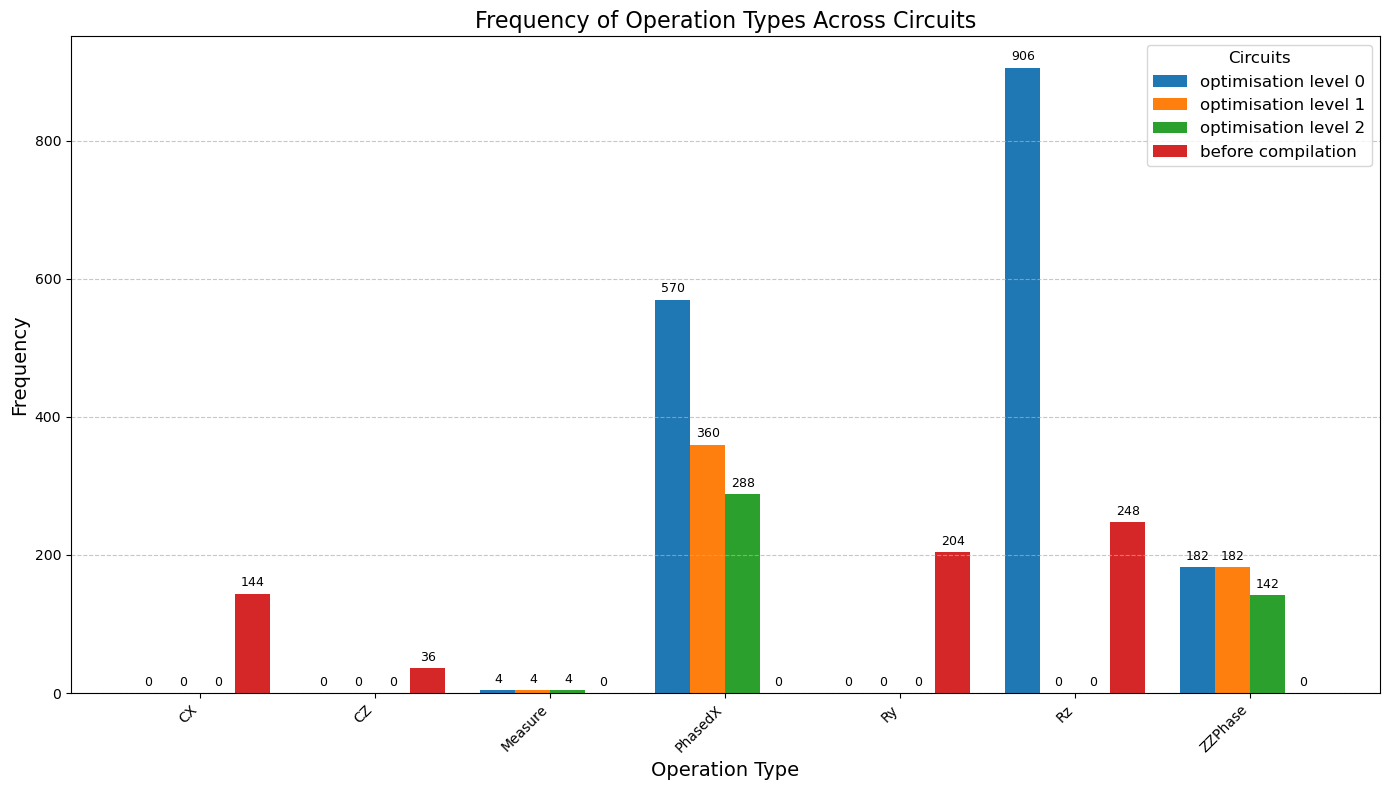

In [17]:
plot_grouped_op_type_frequencies(circuits, labels=[f'optimisation level {optimisation_level}' for optimisation_level in range(3)]+['before compilation'])

## Execute circuits

In [28]:
def submit_execution_jobs(compiled_circuits_dict, circuit_type, nshots=2000):
    """
    Submits execution jobs for compiled circuits to the QNX emulator.

    Parameters:
    - compiled_circuits_dict (dict): Dictionary mapping optimization levels to compile jobs.
    - circuit_type (str): Type of circuit ('VQE' or 'GCI') for labeling purposes.
    - nshots (int): Number of shots per circuit.

    Returns:
    - execution_jobs_dict (dict): Dictionary mapping optimization levels to execution jobs.
    """
    execution_jobs_dict = {}
    
    for opt_level, compile_job in compiled_circuits_dict.items():
        # Retrieve compiled circuits from the compile job
        
        # Submit execution jobs for each compiled circuit
        execute_job = qnx.start_execute_job(
            name=f"execute_job_{circuit_type}_opt_{opt_level}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
            circuits=compile_job,
            backend_config=qnx.QuantinuumConfig(device_name='H1-Emulator'),
            n_shots=[nshots]*len(vqe_circuit_ref_list)
        )
        
        execution_jobs_dict[opt_level] = execute_job
        print(f"Submitted execution job for {circuit_type} at optimization level {opt_level}.")
    
    return execution_jobs_dict

def retrieve_execution_results(execution_jobs_dict, circuit_type):
    """
    Waits for execution jobs to complete and retrieves the results.

    Parameters:
    - execution_jobs_dict (dict): Dictionary mapping optimization levels to execution jobs.
    - circuit_type (str): Type of circuit ('VQE' or 'GCI') for labeling purposes.

    Returns:
    - results_dict (dict): Dictionary mapping optimization levels to list of results per circuit.
    """
    results_dict = {}
    
    for opt_level, execute_job in execution_jobs_dict.items():
        print(f"Waiting for execution job of {circuit_type} at optimization level {opt_level} to complete...")
        # Wait until the execution job is done
        execute_job.wait_until_done()
        
        # Retrieve the execution results
        execution_results = [job.download_result() for job in qnx.jobs.results(execute_job)]
        
        results_dict[opt_level] = execution_results
        print(f"Retrieved results for {circuit_type} at optimization level {opt_level}.")
    
    return results_dict


In [30]:
# Define your optimization levels
optimization_levels = [0, 1, 2]

# Dictionaries to store compiled circuits per optimization level (already defined in your code)
# vqe_compiled_circuits_dict = {}
# gci_compiled_circuits_dict = {}

# Assuming the compiled circuits are already in vqe_compiled_circuits_dict and gci_compiled_circuits_dict

# Submit execution jobs for VQE circuits
vqe_execution_jobs_dict = submit_execution_jobs(
    compiled_circuits_dict=vqe_compiled_circuits_dict,
    circuit_type='VQE',
    nshots=2000
)

# Submit execution jobs for GCI circuits
gci_execution_jobs_dict = submit_execution_jobs(
    compiled_circuits_dict=gci_compiled_circuits_dict,
    circuit_type='GCI',
    nshots=2000
)

Submitted execution job for VQE at optimization level 0.
Submitted execution job for VQE at optimization level 1.
Submitted execution job for VQE at optimization level 2.
Submitted execution job for GCI at optimization level 0.
Submitted execution job for GCI at optimization level 1.
Submitted execution job for GCI at optimization level 2.


## Retrieve execution results

In [39]:
# check execution status
for i in range(3):
    print(f'Execution status for optimisation level {i}')
    print(qnx.jobs.status(vqe_execution_jobs_dict[i]))
    print(qnx.jobs.status(gci_execution_jobs_dict[i]))

Execution status for optimisation level 0
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 11, 19, 6, 50, 51, 586720, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 11, 19, 6, 47, 25, 569743, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 11, 19, 6, 50, 49, 243685, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 11, 19, 6, 51, 8, 4648, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 11, 19, 6, 47, 26, 713668, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 11, 19, 6, 50, 55, 108206, tzinfo=datetime.timezone.utc), cancelled_ti

In [ ]:
# retrieve execution results
vqe_results = {}
gci_results = {}
for i in range(3):
    print(f'Retrieving results for optimisation level {i}')
    vqe_result = [job.download_result() for job in qnx.jobs.results(vqe_execution_jobs_dict[i])]
    gci_result = [job.download_result() for job in qnx.jobs.results(gci_execution_jobs_dict[i])]
    vqe_results[i] = vqe_result
    gci_results[i] = gci_result

Retrieving results for optimisation level 0
Retrieving results for optimisation level 1
Retrieving results for optimisation level 2


In [41]:
for i in range (3):
    print(f'Expectations from ptimisation level {i}')
    expval_vqe = compute_expectation_value_from_results(
    vqe_results[i], measurement_setup, ham_quantinuum
)
    expval_gci = compute_expectation_value_from_results(
    gci_results[i], measurement_setup, ham_quantinuum
)
    print('vqe:', expval_vqe)
    print('gci:', expval_gci)

Expectations from ptimisation level 0
vqe: -6.143000000000001
gci: -5.503
Expectations from ptimisation level 1
vqe: -6.1129999999999995
gci: -5.485
Expectations from ptimisation level 2
vqe: -5.987
gci: -6.286
